<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L12/DQN_atari_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "gymnasium[atari]" flax optax jax jaxlib

In [2]:
# ─── 1) Imports & Env setup ──────────────────────────────────────────────────
import ale_py                                    # registers ALE/Breakout-v5
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing
import numpy as np
from collections import deque
import random

import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

# Custom FrameStack compatible with Gymnasium new API
class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        super().__init__(env)
        self.k = k
        self.frames = deque(maxlen=k)
        low  = np.repeat(env.observation_space.low[np.newaxis], k, axis=0)
        high = np.repeat(env.observation_space.high[np.newaxis], k, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=env.observation_space.dtype)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.frames.clear()
        for _ in range(self.k):
            self.frames.append(obs)
        return np.stack(self.frames, 0), info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.frames.append(obs)
        return np.stack(self.frames, 0), reward, terminated, truncated, info

# Build and wrap Breakout
base_env = gym.make(
    "ALE/Breakout-v5",
    render_mode="rgb_array",
    frameskip=1,                  # disable ALE-internal skip
    repeat_action_probability=0.0
)
env = AtariPreprocessing(base_env, screen_size=84, grayscale_obs=True, frame_skip=4, noop_max=30)
env = FrameStack(env, k=4)

obs_shape = env.observation_space.shape   # (4,84,84)
n_actions  = env.action_space.n

# ─── 2) Hyperparameters ────────────────────────────────────────────────────
seed            = 0
gamma           = 0.99
lr              = 2e-4
buffer_size     = 5_000
batch_size      = 32
min_replay_size = 10_000
total_steps     = 500_000   # or higher, depending on your compute
target_update   = 100    # update target every 10k steps
update_freq     = 4         # train every 4 env steps
eps_start       = 0.9
eps_end         = 0.1
eps_decay_steps = total_steps

# ─── 3) Replay Buffer ─────────────────────────────────────────────────────
replay_buffer = deque(maxlen=buffer_size)

# ─── 4) Flax Q‐Network ─────────────────────────────────────────────────────
class DQN(nn.Module):
    n_actions: int

    @nn.compact
    def __call__(self, x):
        # x: [B, C, H, W]   pixel range [0,255]
        x = x.astype(jnp.float32) / 255.0

        # ── TRANSPOSE NCHW → NHWC ──────────────────────────────────────────────
        x = jnp.transpose(x, (0, 2, 3, 1))  # now [B, H, W, C=4]

        # ── CONV LAYERS ────────────────────────────────────────────────────────
        x = nn.Conv(features=32, kernel_size=(8,8), strides=(4,4), padding='VALID')(x)
        x = nn.relu(x)
        x = nn.Conv(features=64, kernel_size=(4,4), strides=(2,2), padding='VALID')(x)
        x = nn.relu(x)
        x = nn.Conv(features=64, kernel_size=(3,3), strides=(1,1), padding='VALID')(x)
        x = nn.relu(x)

        # ── FLATTEN + DENSE ────────────────────────────────────────────────────
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=512)(x)
        x = nn.relu(x)
        return nn.Dense(features=self.n_actions)(x)

# Initialize online & target nets + optimizer
rng = jax.random.PRNGKey(seed)
online_net = DQN(n_actions)
target_net = DQN(n_actions)
dummy_obs = jnp.zeros((1, *obs_shape), dtype=jnp.uint8)
params_online = online_net.init(rng, dummy_obs)
params_target = params_online
optimizer = optax.adam(lr)
opt_state  = optimizer.init(params_online)

# ─── 5) Epsilon‐greedy & train step ─────────────────────────────────────────
def select_action(params, obs, eps):
    if random.random() < eps:
        return env.action_space.sample()
    qv = online_net.apply(params, obs[None])
    return int(jnp.argmax(qv))

@jax.jit
def train_step(params, target_params, opt_state, batch):
    def loss_fn(p):
        q = online_net.apply(p, batch['obs'])
        q_a = jnp.take_along_axis(q, batch['act'][:,None], axis=1).squeeze()
        q_next = target_net.apply(target_params, batch['next_obs'])
        max_next = jnp.max(q_next, axis=1)
        target = batch['rew'] + gamma * max_next * (1. - batch['done'])
        return jnp.mean((q_a - target)**2)
    grads = jax.grad(loss_fn)(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

# ─── 6) Populate initial buffer ───────────────────────────────────────────
obs, info = env.reset(seed=seed)
for _ in range(min_replay_size):
    a = env.action_space.sample()
    next_obs, r, term, trunc, info = env.step(a)
    replay_buffer.append((obs, a, r, next_obs, float(term or trunc)))
    obs = next_obs if not (term or trunc) else env.reset()[0]

# ─── 7) Training Loop ─────────────────────────────────────────────────────
obs, info = env.reset()
eps = eps_start
step_count = 0
episode_reward = 0
all_rewards = []

while step_count < total_steps:
    # decay ε
    eps = max(eps_end, eps_start - (step_count/eps_decay_steps)*(eps_start-eps_end))
    a = select_action(params_online, obs, eps)
    next_obs, r, term, trunc, info = env.step(a)
    done = term or trunc
    replay_buffer.append((obs, a, r, next_obs, float(done)))
    obs = next_obs
    episode_reward += r
    step_count += 1

    # training
    if step_count % update_freq == 0:
        batch = random.sample(replay_buffer, batch_size)
        batch = {
            'obs':      jnp.array([b[0] for b in batch]),
            'act':      jnp.array([b[1] for b in batch]),
            'rew':      jnp.array([b[2] for b in batch], dtype=jnp.float32),
            'next_obs': jnp.array([b[3] for b in batch]),
            'done':     jnp.array([b[4] for b in batch], dtype=jnp.float32),
        }
        params_online, opt_state = train_step(params_online, params_target, opt_state, batch)

    # target update
    if step_count % target_update == 0:
        params_target = params_online
        #target_update *= 1.2

    if done:
        all_rewards.append(episode_reward)
        print(f"Steps {step_count:7d} | Ep Reward: {episode_reward:6.1f} | ε={eps:.3f}")
        obs, info = env.reset()
        episode_reward = 0

# ─── 8) Final Logging ─────────────────────────────────────────────────────
print("\nTraining complete.")
print("Last 10 episode rewards:", all_rewards[-10:])
print("Mean of last 10:", np.mean(all_rewards[-10:]))


Steps     138 | Ep Reward:    0.0 | ε=0.900
Steps     360 | Ep Reward:    2.0 | ε=0.899
Steps     533 | Ep Reward:    1.0 | ε=0.899
Steps     830 | Ep Reward:    4.0 | ε=0.899
Steps    1056 | Ep Reward:    2.0 | ε=0.898
Steps    1187 | Ep Reward:    0.0 | ε=0.898
Steps    1325 | Ep Reward:    0.0 | ε=0.898
Steps    1456 | Ep Reward:    0.0 | ε=0.898
Steps    1586 | Ep Reward:    0.0 | ε=0.897
Steps    1859 | Ep Reward:    3.0 | ε=0.897
Steps    2002 | Ep Reward:    0.0 | ε=0.897
Steps    2131 | Ep Reward:    0.0 | ε=0.897
Steps    2324 | Ep Reward:    1.0 | ε=0.896
Steps    2514 | Ep Reward:    2.0 | ε=0.896
Steps    2641 | Ep Reward:    0.0 | ε=0.896
Steps    2843 | Ep Reward:    1.0 | ε=0.895
Steps    2977 | Ep Reward:    0.0 | ε=0.895
Steps    3157 | Ep Reward:    1.0 | ε=0.895
Steps    3323 | Ep Reward:    1.0 | ε=0.895
Steps    3516 | Ep Reward:    1.0 | ε=0.894
Steps    3859 | Ep Reward:    5.0 | ε=0.894
Steps    4031 | Ep Reward:    1.0 | ε=0.894
Steps    4202 | Ep Reward:    1.

In [3]:
from gymnasium.wrappers import RecordVideo
import glob
from IPython.display import Video

# Wrap your *preprocessed* env for recording
recorded = RecordVideo(
    env,                          # this is your AtariPreprocessing+FrameStack env
    video_folder="",
    episode_trigger=lambda ep: True,
    name_prefix="breakout_eval"
)

# Run exactly one episode
obs, info = recorded.reset(seed=123)
done = False
i=0
while not done and i <200:
    i+=1
    action = select_action(params_online, obs, eps=0.0)
    obs, reward, terminated, truncated, info = recorded.step(action)
    done = terminated or truncated
recorded.close()

# Find and embed the just-written MP4
mp4 = sorted(glob.glob("breakout_eval-episode-*.mp4"))[-1]
Video(mp4, embed=True)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


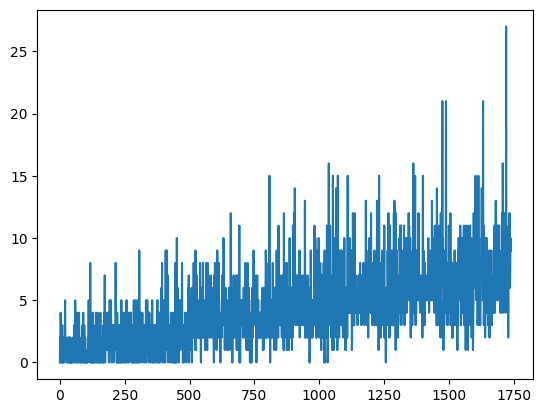

In [4]:
import matplotlib.pyplot as plt
plt.plot(all_rewards)